# **Carga, exploración inicial y preparación de los datos.**
Este notebook tiene como propósito proporcionar una base sólida para el análisis posterior, mediante la **conexión a la fuente de datos**, la **revisión exhaustiva** de su estructura, la **exploración estadística inicial (EDA)** y la **preparación técnica necesaria para su procesamiento analítico**. Se abordan tareas fundamentales como la imputación de valores ausentes, el tratamiento de variables categóricas, la detección de outliers y la normalización de variables numéricas, asegurando así la calidad e integridad del conjunto de datos.

## **Importación de librerías y configuración general.**
Se cargan las librerías necesarias (incluidas en el archivo `requirements.txt`) para trabajar con bases de datos, manipulación de datos y archivos. También se desactivan ciertos mensajes de advertencia que podrían ensuciar la salida.

In [12]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
from dotenv import load_dotenv

warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)

## **Conexión a la fuente de datos.**
Se establece un flujo lógico de extracción de datos que prioriza la lectura desde un archivo local si este está disponible, o bien, accede a la base de datos en Azure SQL en modo lectura. Se extraen todas las columnas de la tabla, garantizando la integridad del esquema original. La estructura tabular se convierte en un conjunto de trabajo sobre el cual se llevarán a cabo las transformaciones posteriores.

In [13]:
# Carga de variables de entorno: Configuración de Azure. Definidas en GitHub Secrets.
load_dotenv()

# Lectura de variables de entorno.
AZURE_SERVER = os.getenv("AZURE_SERVER")
AZURE_DATABASE = os.getenv("AZURE_DATABASE")
AZURE_DRIVER = '{ODBC Driver 17 for SQL Server}'
AZURE_AUTH = os.getenv("AZURE_AUTH")
CSV_PATH = "../data/IA_Client_Segment_sample.csv"

# Carga condicional de datos.
if os.path.exists(CSV_PATH):
    print("Archivo local encontrado. Cargando datos desde CSV.")
    df = pd.read_csv(CSV_PATH)
else:
    print("Archivo local no encontrado. Conectando a Azure SQL...")

    azure_conn_str = (
        f"DRIVER={AZURE_DRIVER};"
        f"SERVER={AZURE_SERVER};"
        f"DATABASE={AZURE_DATABASE};"
        f"Authentication={AZURE_AUTH}"
    )

    query = "SELECT * FROM [DATAEX].[IA_Client_Segment_MODIFICADO]"
    conn = pyodbc.connect(azure_conn_str)
    df = pd.read_sql_query(query, conn)
    conn.close()

df.set_index('ID', inplace=True)
df.head()

Archivo local no encontrado. Conectando a Azure SQL...


,Genero,Casado,Edad,Graduado,Profesion,Experiencia_laboral,Gastoscore,Family_Size,anno_nacimiento,Generacion,Ingresos_anuales_brutos,Provincia,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Campanna_anno
ID,,,,,,,,,,,,,,,,,
CLI10,F,Si,67,Si,Ingeniero,+20annos,Bajo,3,1957,Generacion X,93442,Segovia,1385.0,80,True,195,NaN
CLI100,M,Si,64,Si,Medico,+20annos,Medio,2,1960,Generacion X,99774,Alicante,1052.0,50,True,360,5.0
CLI1000,M,Si,65,Si,Artista,+20annos,Medio,3,1959,Generacion X,36756,Toledo,1717.0,30,False,407,3.0
CLI10000,M,No,33,No,Funcionario,10-20annos,Bajo,4,1991,Millennials,24616,Leon,1606.0,30,False,544,4.0
CLI10001,M,Si,52,No,Otros,+20annos,Medio,2,1972,Generacion X,29834,LLeida,1346.0,30,True,170,NaN


## **Recopilación de datos: Verificación estructural del dataset.**
La recopilación de datos es una etapa fundamental en la construcción de cualquier modelo de predicción. En este notebook, aplicaremos técnicas para **limpiar y preparar el dataset** antes de su uso en el modelado y evaluación en el análisis exploratorio (EDA). Identificaremos la presencia de **valores nulos, datos duplicados, variables categóricas y valores atípicos**:
- Manejo de valores nulos mediante eliminación o imputación.
- Eliminación de duplicados para evitar sesgos en el modelo.
- Conversión y corrección de tipos de datos para garantizar coherencia.

Al finalizar este proceso, copiaremos el dataset limpio en una nueva variable **`df_clean`** en caso de que se quiera volver a utilizar.

In [14]:
# Verificación de dimensiones generales.
print("Dimensiones del dataset:")
print(f"- Número de filas: {df.shape[0]}")
print(f"- Número de columnas: {df.shape[1]}")

Dimensiones del dataset:
- Número de filas: 10806
- Número de columnas: 17


In [15]:
df.columns

Index(['Genero', 'Casado', 'Edad', 'Graduado', 'Profesion',
       'Experiencia_laboral', 'Gastoscore', 'Family_Size', 'anno_nacimiento',
       'Generacion', 'Ingresos_anuales_brutos', 'Provincia',
       'Digital_encuesta', 'Gasto_medio_mensual_cuota', 'Abandono',
       'Dias_cliente', 'Campanna_anno'],
      dtype='object')

In [16]:
df.dtypes

Genero                        object
Casado                        object
Edad                           int64
Graduado                      object
Profesion                     object
Experiencia_laboral           object
Gastoscore                    object
Family_Size                    int64
anno_nacimiento                int64
Generacion                    object
Ingresos_anuales_brutos        int64
Provincia                     object
Digital_encuesta             float64
Gasto_medio_mensual_cuota      int64
Abandono                        bool
Dias_cliente                   int64
Campanna_anno                float64
dtype: object

Se nos muestra que tiene un total de 17 columnas que deberemos de examinar para saber cuáles tener en cuenta a la hora de la realización de nuestro estudio y lo que significan cada una de ellas.
- **Género:** Sexo del cliente, clasificado como masculino o femenino. *Tipo de dato: categórico (M / F)*.
- **Estado civil:** Condición conyugal del cliente, indicado como casado o no casado. *Tipo de dato: categórico (Sí / No)*.
- **Edad:** Edad actual del cliente en años. *Tipo de dato: numérico (entero)*.
- **Nivel educativo:** Indica si el cliente ha completado estudios universitarios. *Tipo de dato: categórico (Sí / No)*.
- **Profesión:** Ocupación profesional del cliente. *Tipo de dato: categórico*.
- **Experiencia laboral:** Número de años de experiencia laboral acumulada por el cliente. *Tipo de dato: categórico (ordinal)*.
- **Nivel de gasto:** Nivel de gasto estimado del cliente o su grado de apalancamiento financiero. *Tipo de dato: categórico (Bajo / Medio / Alto)*.
- **Tamaño familiar:** Número total de integrantes del núcleo familiar del cliente. *Tipo de dato: numérico (entero)*.
- **Año de nacimiento:** Año de nacimiento del cliente. *Tipo de dato: numérico (entero)*.
- **Generación demográfica:** Generación a la que pertenece el cliente según su año de nacimiento. *Tipo de dato: categórico*.
- **Ingresos anuales brutos:** Ingresos anuales totales del cliente antes de impuestos o deducciones. *Tipo de dato: numérico (decimal)*.
- **Provincia de residencia:** Localización geográfica del cliente a nivel provincial. *Tipo de dato: categórico*.
- **Índice de digitalización:** Nivel de interacción digital del cliente con los canales de la empresa. *Tipo de dato: numérico (entero)*.
- **Gasto medio mensual en cuota:** Gasto promedio mensual del cliente en servicios contratados con pago periódico. *Tipo de dato: numérico (entero)*.
- **Abandono:** Indica si el cliente ha causado baja voluntaria del servicio. *Tipo de dato: categórico (0 = activo, 1 = abandonado)*.
- **Días como cliente:** Número total de días que el cliente ha permanecido activo. *Tipo de dato: numérico (entero)*.
- **Campaña del año:** Tipo o clasificación de la campaña comercial aplicada al cliente durante el año. *Tipo de dato: numérico (decimal)*.

### **Análisis descriptivo general.**
Con el objetivo de comprender la estructura subyacente y las características generales del conjunto de datos, se realiza en esta sección un análisis descriptivo general de datos enfocado en las variables proporcionadas por la tabla. Esta etapa constituye un paso esencial dentro del proceso de análisis, ya que permite:
- Evaluar la calidad y completitud de los datos (presencia de valores nulos, duplicados, errores de formato).
- Identificar la distribución estadística de las variables numéricas (medias, medianas, rangos, presencia de outliers).
- Detectar asimetrías o sesgos que puedan afectar la normalización o interpretación de los datos.
- Obtener una visión preliminar de la diversidad y cardinalidad de las variables categóricas.
- Establecer criterios objetivos para la toma de decisiones en etapas posteriores como la imputación, codificación y selección de variables para la segmentación.

In [17]:
df.describe(include='all')

,Genero,Casado,Edad,Graduado,Profesion,Experiencia_laboral,Gastoscore,Family_Size,anno_nacimiento,Generacion,Ingresos_anuales_brutos,Provincia,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Campanna_anno
count,10806,10616,10806.000000,10703,10806,10806,10806,10806.000000,10806.000000,10806,10806.000000,10806,10806.000000,10806.000000,10806,10806.000000,5099.000000
unique,2,2,NaN,2,9,3,3,NaN,NaN,4,NaN,50,NaN,NaN,2,NaN,NaN
top,M,Si,NaN,Si,Artista,+20annos,Bajo,NaN,NaN,Generacion X,NaN,Madrid,NaN,NaN,False,NaN,NaN
freq,5904,6217,NaN,6637,3354,6289,6574,NaN,NaN,4871,NaN,326,NaN,NaN,7586,NaN,NaN
mean,NaN,NaN,47.920415,NaN,NaN,NaN,NaN,2.764390,1976.075236,NaN,56113.470387,NaN,1597.302610,45.285027,NaN,298.006293,3.592077
std,NaN,NaN,18.432100,NaN,NaN,NaN,NaN,1.548241,18.431804,NaN,35458.081118,NaN,2135.573309,28.674032,NaN,148.844349,1.243383
min,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,1.000000,1926.000000,NaN,12003.000000,NaN,7.000000,30.000000,NaN,30.000000,1.000000
25%,NaN,NaN,33.000000,NaN,NaN,NaN,NaN,2.000000,1966.000000,NaN,24986.250000,NaN,876.000000,30.000000,NaN,177.000000,3.000000
50%,NaN,NaN,45.000000,NaN,NaN,NaN,NaN,2.000000,1979.000000,NaN,43628.000000,NaN,1267.000000,30.000000,NaN,289.000000,4.000000
75%,NaN,NaN,58.000000,NaN,NaN,NaN,NaN,4.000000,1991.000000,NaN,86678.500000,NaN,1678.000000,50.000000,NaN,401.000000,5.000000


A partir del análisis estadístico y estructural realizado sobre el dataset, se extraen las siguientes conclusiones clave. Estas observaciones no solo describen el estado actual de los datos, sino que permiten identificar oportunidades y limitaciones de cara a su utilización en modelos analíticos no supervisados, particularmente en técnicas de segmentación.


1. **Presencia moderada de valores ausentes:** Se detecta la existencia de valores nulos en múltiples columnas, aunque en la mayoría de los casos la proporción es baja (inferior al 2%). Sin embargo, la variable **`Campaña Anual`** presenta un porcentaje de valores ausentes superior al 50%, lo cual compromete su utilidad directa en fases analíticas posteriores sin un tratamiento adecuado.

2. **Cobertura generacional amplia y balanceada:** La variable **`Edad`** presenta una distribución amplia, con valores entre 20 y 98 años, y una mediana cercana a los 45 años. Esto indica la presencia de clientes pertenecientes a distintas generaciones, lo cual enriquece el análisis al permitir identificar diferencias de comportamiento asociadas al ciclo de vida.

3. **Alta dispersión en ingresos y gasto mensual:** Las variables **`Ingresos anuales brutos`** y **`Gasto medio mensual en cuota`** presentan una alta dispersión y valores máximos muy alejados de la mediana, lo que sugiere la **presencia de outliers** o segmentos de clientes con comportamientos económicos muy distintos. Este tipo de variables requerirá una normalización para evitar distorsiones en el análisis.

4. **Clientes mayoritariamente recientes:** La variable **`Días como cliente`** muestra una media cercana a los 300 días, lo que sugiere que la mayoría de los registros pertenecen a clientes con menos de dos años de antigüedad. Este aspecto es relevante, ya que puede limitar la interpretación de métricas de fidelización o ciclos de vida largos.

5. **Diversidad en ocupación y perfil de gasto:** La variable **`Profesión`** presenta una diversidad razonable (9 categorías), y **`Gasto Score`** está bien distribuida entre bajo, medio y alto. Ambas variables podrían ser útiles para segmentar a los clientes en función de su perfil socioeconómico, especialmente cuando se combinan con nivel educativo e ingresos.

6. **Alta cardinalidad geográfica:** La variable **`Provincia`** presenta 50 categorías distintas, lo que puede aportar valor en términos de análisis regional, pero también podría introducir ruido en modelos de clustering si no se agrupan previamente o se codifican con criterios espaciales.

7. **Digitalización potencialmente útil como variable de comportamiento:** El **`Índice de digitalización`** refleja un aspecto clave del comportamiento del cliente que puede correlacionarse con el abandono, la retención o la preferencia por canales digitales. Su distribución deberá ser explorada con mayor detalle en fases posteriores.

### **Tratamiento de valores duplicados.**
Los datos duplicados pueden sesgar los resultados y generar inconsistencias en el análisis. Aquí revisaremos si existen registros repetidos en el dataset y aplicaremos las estrategias necesarias para eliminarlos sin perder información relevante.

In [18]:
df.duplicated().sum() # Columnas duplicadas

np.int64(0)

In [19]:
df.drop_duplicates(inplace = True)

In [20]:
df.shape

(10806, 17)

### **Errores ortográficos.**
En muchos casos, los datos pueden contener caracteres incorrectos, como símbolos (`-`, `?`, `#`, `*`, etc.), diferencias en mayúsculas y espacios en blanco, lo que puede afectar el análisis y modelado. En esta sección, listamos los valores únicos de cada columna categórica para detectar inconsistencias o entradas incorrectas.


In [21]:
for col in df.select_dtypes(include=['object']).columns:
    print('{} : {}'.format(col,df[col].unique()))

Genero : ['F' 'M']
Casado : ['Si' 'No' None]
Graduado : ['Si' 'No' None]
Profesion : ['Ingeniero' 'Medico' 'Artista' 'Funcionario' 'Otros' 'Ejecutivo'
 'Construccion' 'Negocios/empresa' 'Servicios']
Experiencia_laboral : ['+20annos' '10-20annos' '<10annos']
Gastoscore : ['Bajo' 'Medio' 'Alto']
Generacion : ['Generacion X' 'Millennials' 'Generacion Silenciosa' 'Generacion Z']
Provincia : ['Segovia' 'Alicante' 'Toledo' 'Leon' 'LLeida' 'Ciudad Real' 'i\x81vila'
 'Guipiºzcoa' 'Vizcaya' 'Orense' 'Castellon' 'Pontevedra' 'Almeri\xada'
 'Valladolid' 'Jaen' 'Lugo' 'Santa Cruz de Tenerife' 'Albacete' 'Huelva'
 'Salamanca' 'Ceuta' 'Baleares' 'Gerona' 'Barcelona' 'Sevilla'
 'Guadalajara' 'Soria' 'Caceres' 'Madrid' 'Cordoba' 'Burgos' 'Cadiz'
 'Navarra' 'Melilla' 'Granada' 'Badajoz' 'Valencia' 'Tarragona'
 'La Corui±a' 'Las Palmas' 'Murcia' 'Palencia' 'La Rioja' 'Teruel'
 'Zamora' 'Zaragoza' 'i\x81lava' 'Cuenca' 'Huesca' 'Malaga']


In [22]:
# Reemplazo de nombres mal codificados por errores UTF-8/Latin-1 en la columna 'Provincia'.
reemplazos = {
    'i\x81vila': 'Ávila',
    'Guipiºzcoa': 'Guipúzcoa',
    'Almeri\xada': 'Almería',
    'La Corui±a': 'La Coruña',
    'i\x81lava': 'Álava'
}

df['Provincia'] = df['Provincia'].replace(reemplazos)

Tras revisar los valores únicos de las variables categóricas, se identificaron errores de codificación en la columna **`Provincia`**, producto de una mala interpretación de caracteres especiales (como tildes y letras acentuadas) debido a conflictos entre codificaciones UTF-8 y Latin-1. Estos errores fueron corregidos mediante el reemplazo de los valores afectados, asegurando así la calidad y consistencia de los datos en dicha columna.

### **Tratamiento de valores ausentes.**
El tratamiento de valores ausentes constituye una etapa fundamental para garantizar la completitud y consistencia del dataset antes de aplicar modelos analíticos.

En particular, se destacó en el **Análisis descriptivo general** la situación de la variable **`Campaña Anual`**, que presenta un nivel significativo de ausencia de datos. Ante este escenario, se consideran varias alternativas viables:

- **Imputar una categoría genérica** como “No aplica” o “Sin campaña”, en caso de que los nulos correspondan a clientes que efectivamente no han recibido campañas.
- **Excluir la variable del análisis** si se determina que su valor informativo es bajo o que introduce ruido más que valor.

Para el resto de las variables con nulos (por ejemplo, **`Casado`** o **`Graduado`**), cuya proporción de ausencia es moderada, se recomienda una imputación basada en:

- La **moda** de cada variable, si el patrón de ausencia no está correlacionado con el valor objetivo.
- La creación de una categoría específica como “Desconocido” en el caso de variables categóricas.
- Eliminación de dichos registros.

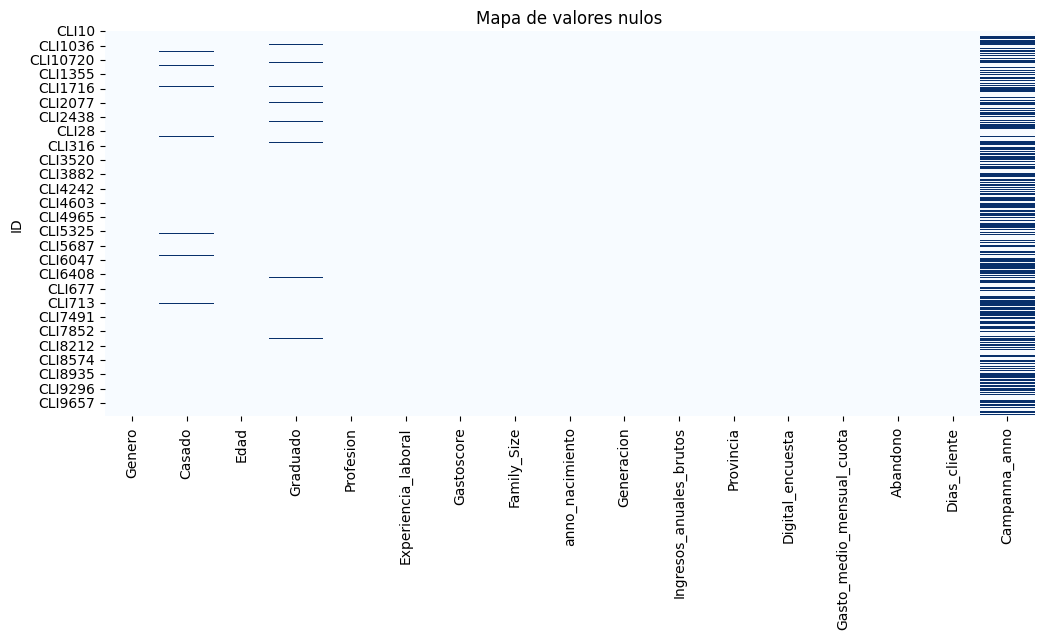

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(df.isnull(), cbar=False, cmap="Blues")
plt.title("Mapa de valores nulos")
plt.show()

La calidad general del dataset es adecuada. El heatmap confirma lo visto en el análisis descriptivo:
- **`Campaña Anual`** presenta muchos nulos. Se puede imputar como “Sin campaña” o excluir la variable si no aporta valor.
- Variables como **`Casado`** o **`Graduado`** tienen pocos nulos. Se sugiere imputar con la **moda**. También es válida la eliminación si el impacto es mínimo.

In [24]:
df.isnull().sum()

Genero                          0
Casado                        190
Edad                            0
Graduado                      103
Profesion                       0
Experiencia_laboral             0
Gastoscore                      0
Family_Size                     0
anno_nacimiento                 0
Generacion                      0
Ingresos_anuales_brutos         0
Provincia                       0
Digital_encuesta                0
Gasto_medio_mensual_cuota       0
Abandono                        0
Dias_cliente                    0
Campanna_anno                5707
dtype: int64

In [25]:
null_percentage = (df.isnull().sum() / len(df)) * 100 # Porcentaje de valores nulos.
null_percentage[null_percentage > 0]

Casado            1.758282
Graduado          0.953174
Campanna_anno    52.813252
dtype: float64

Al analizar los valores ausentes en el conjunto de datos, se identificaron tres variables con valores nulos.

- En el caso de **`Campaña Anual`**, la mayoría de los registros no contienen información. Se asume que esta ausencia se debe a que los clientes no participaron en ninguna campaña. Por ello, se decide imputar estos valores con un indicador que represente "Sin Campaña" (por ejemplo, el valor 0), considerando que la falta de información tiene un significado real y no es un error de carga.
- Las variables **`Casado`** y **`Graduado`** presentan una cantidad muy reducida de nulos. Dado que su impacto sobre el volumen total de datos es mínimo, se opta por eliminar directamente las filas en las que estas variables no tienen información, sin afectar la representatividad del conjunto.

In [26]:
df['Campanna_anno'] = df['Campanna_anno'].fillna(0).astype(int)
df.dropna(subset=['Graduado', 'Casado'], inplace=True)

### **Manejo de valores atípicos.**
Los valores atípicos pueden afectar la estabilidad del modelo, distorsionar las predicciones y generar ruido en el análisis. Para detectarlos, utilizamos boxplots y aplicamos el método del rango intercuartil (IQR), que nos permite identificar datos extremos en función de su dispersión.

In [27]:
v_continuas = df.select_dtypes(include=['float64', 'int64']).columns

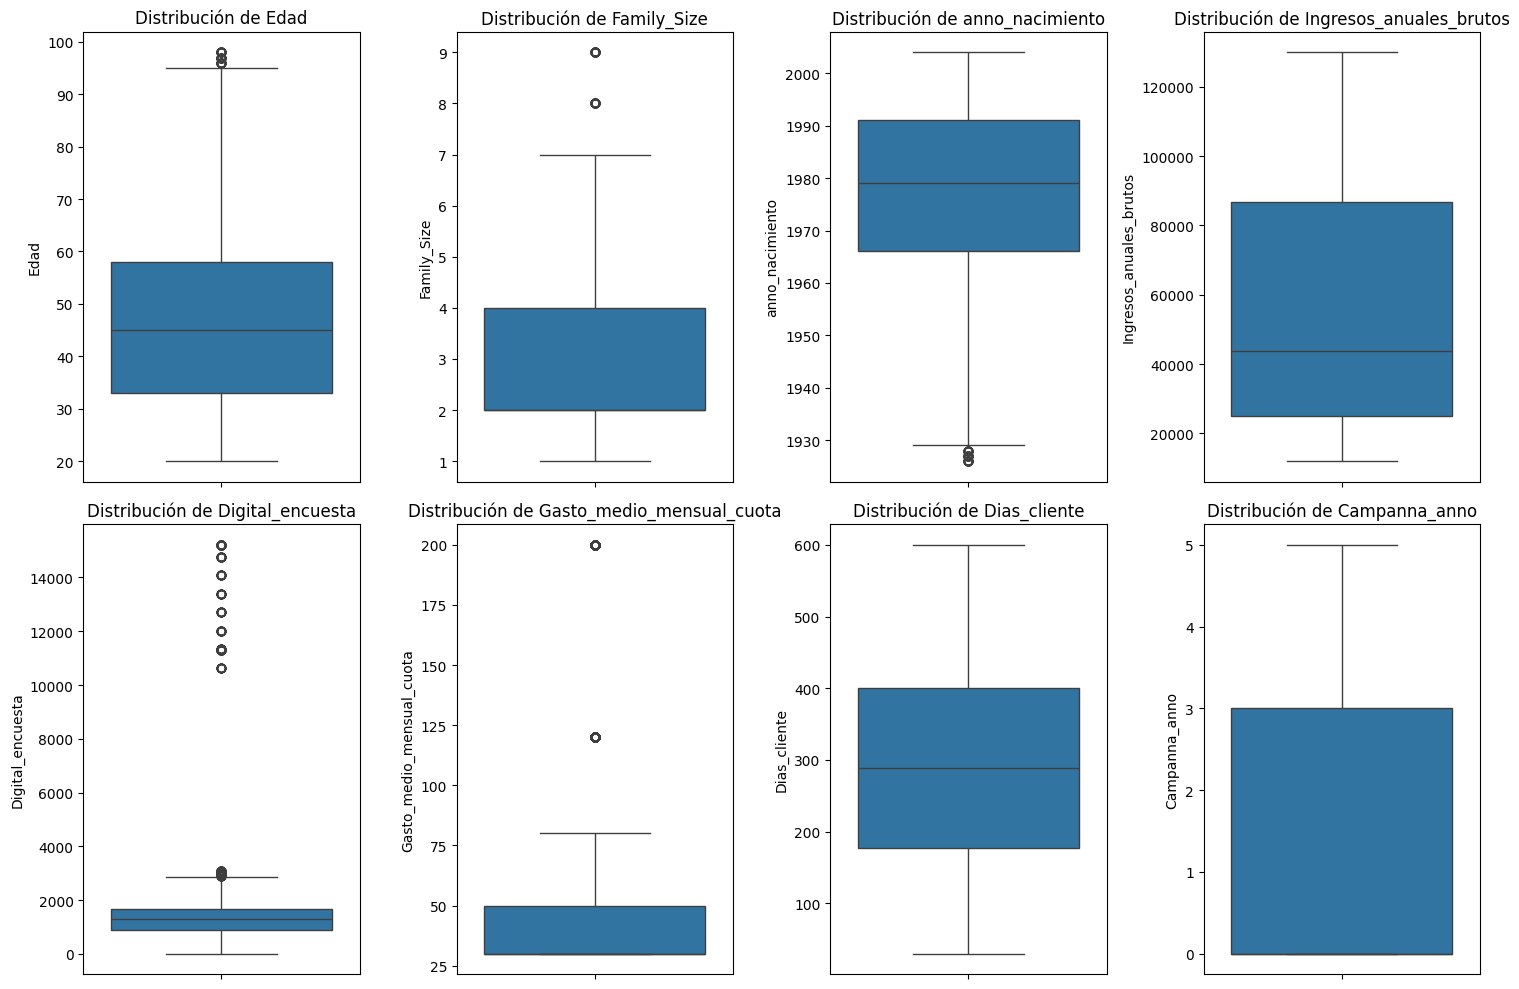

In [28]:
# Crear figura y ejes.
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
axs = axs.flatten()

# Graficar cada variable en un subplot.
for i, col in enumerate(v_continuas):
    sns.boxplot(y=df[col], ax=axs[i])
    axs[i].set_title(f'Distribución de {col}')
    axs[i].set_ylabel(col)

# Eliminar el subplot sobrante si hay.
if len(axs) > len(v_continuas):
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

In [29]:
def outliers_IQR(df, cols):
    outliers = {}
    for col in cols:
        Q1 = df[col].quantile(0.10)
        Q3 = df[col].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Contar valores atípicos.
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()
        # Eliminar outliers.
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df, outliers

In [30]:
df, outliers_detectados = outliers_IQR(df, v_continuas)
print("Valores atípicos detectados:")
for col, count in outliers_detectados.items():
    print(f"- {col}: {count}")

Valores atípicos detectados:
- Edad: 0
- Family_Size: 0
- anno_nacimiento: 0
- Ingresos_anuales_brutos: 0
- Digital_encuesta: 313
- Gasto_medio_mensual_cuota: 140
- Dias_cliente: 0
- Campanna_anno: 0


In [31]:
df_clean = df.copy() # Copia del DataFrame limpio para evitar confusiones en el futuro.

## **Análisis y exploración de datos (EDA).**
El Análisis Exploratorio de Datos (EDA) es una fase clave en cualquier proyecto de análisis o modelado predictivo. Su objetivo es comprender la estructura, la calidad y las características de los datos antes de aplicar cualquier modelo o transformación.

*Este análisis es fundamental para asegurar que los datos sean adecuados antes de entrenar cualquier modelo.*

In [32]:
df.nunique()

Genero                          2
Casado                          2
Edad                           69
Graduado                        2
Profesion                       9
Experiencia_laboral             3
Gastoscore                      3
Family_Size                     9
anno_nacimiento                67
Generacion                      4
Ingresos_anuales_brutos      9277
Provincia                      50
Digital_encuesta              176
Gasto_medio_mensual_cuota       4
Abandono                        2
Dias_cliente                  571
Campanna_anno                   5
dtype: int64

### **Histogramas con KDE de variables continuas.**
Este análisis permite visualizar la distribución de las variables numéricas clave que describen el perfil individual de cada cliente: edad, ingresos, digitalización y antigüedad como cliente. Estas gráficas son esenciales para identificar sesgos, asimetrías o valores extremos que puedan influir en la segmentación si no se transforman o escalan adecuadamente. Entender la forma de estas distribuciones ayuda a decidir qué técnicas aplicar (log-transform, winsorización, normalización) antes de reducir dimensionalidad o agrupar.

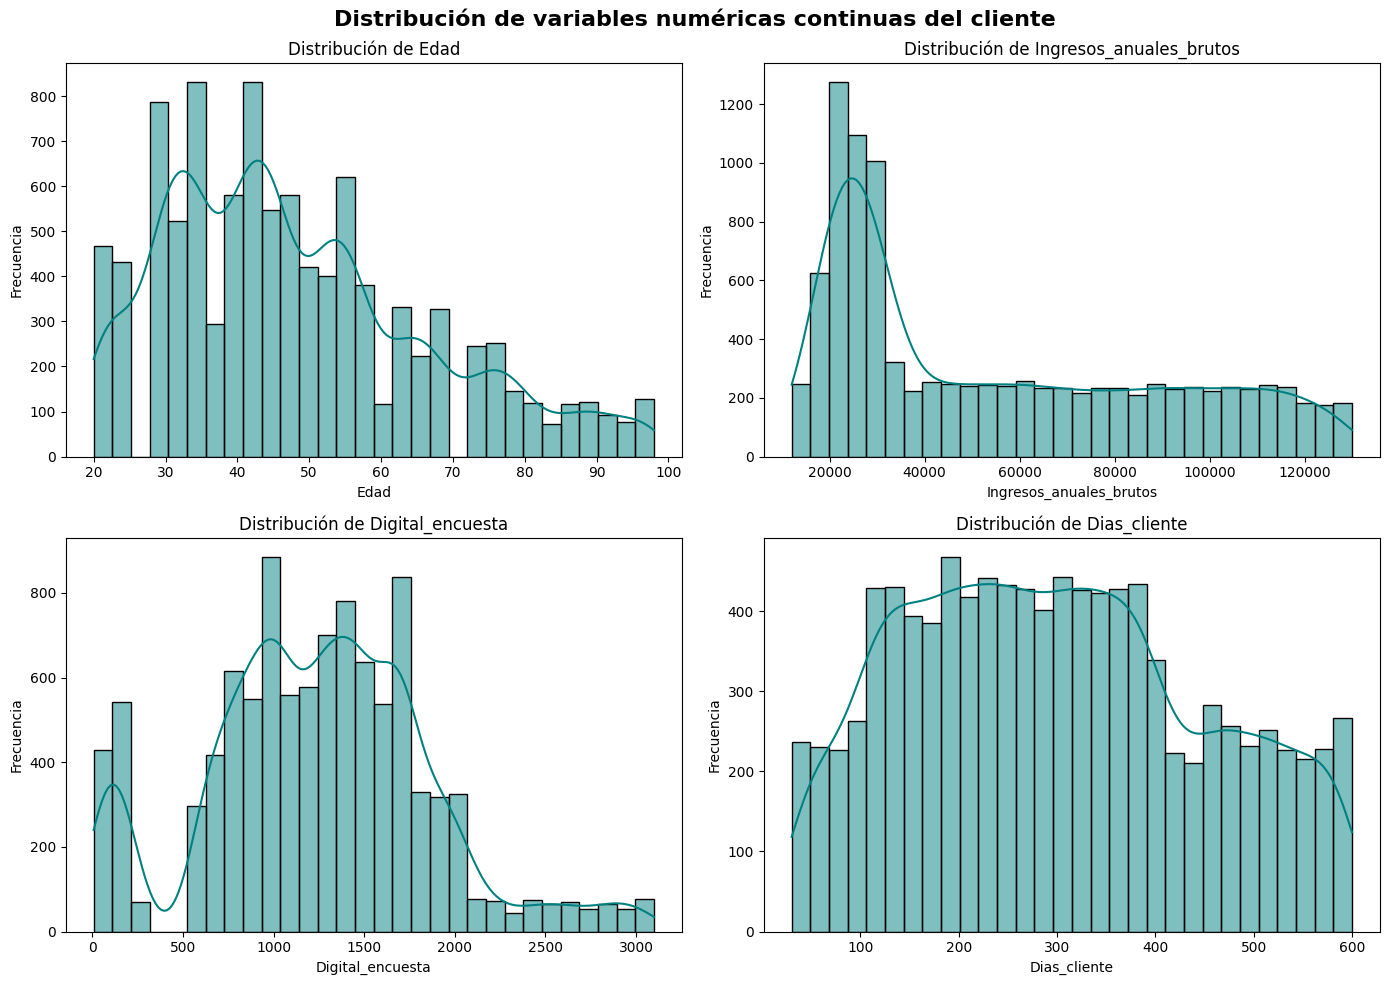

In [33]:
# Histogramas con KDE de variables numéricas continuas.
continuas = ['Edad', 'Ingresos_anuales_brutos', 'Digital_encuesta', 'Dias_cliente']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribución de variables numéricas continuas del cliente', fontsize=16, fontweight='bold')
axes = axes.flatten()

for i, col in enumerate(continuas):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i], color='teal')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

### **Distribución de variables categóricas demográficas y ordinales.**
Las variables categóricas como género, estado civil, nivel educativo, experiencia laboral y generación permiten capturar dimensiones sociodemográficas relevantes del cliente. Analizar su distribución permite validar su representatividad y equilibrio antes de codificarlas numéricamente para su inclusión en el modelo de clustering.

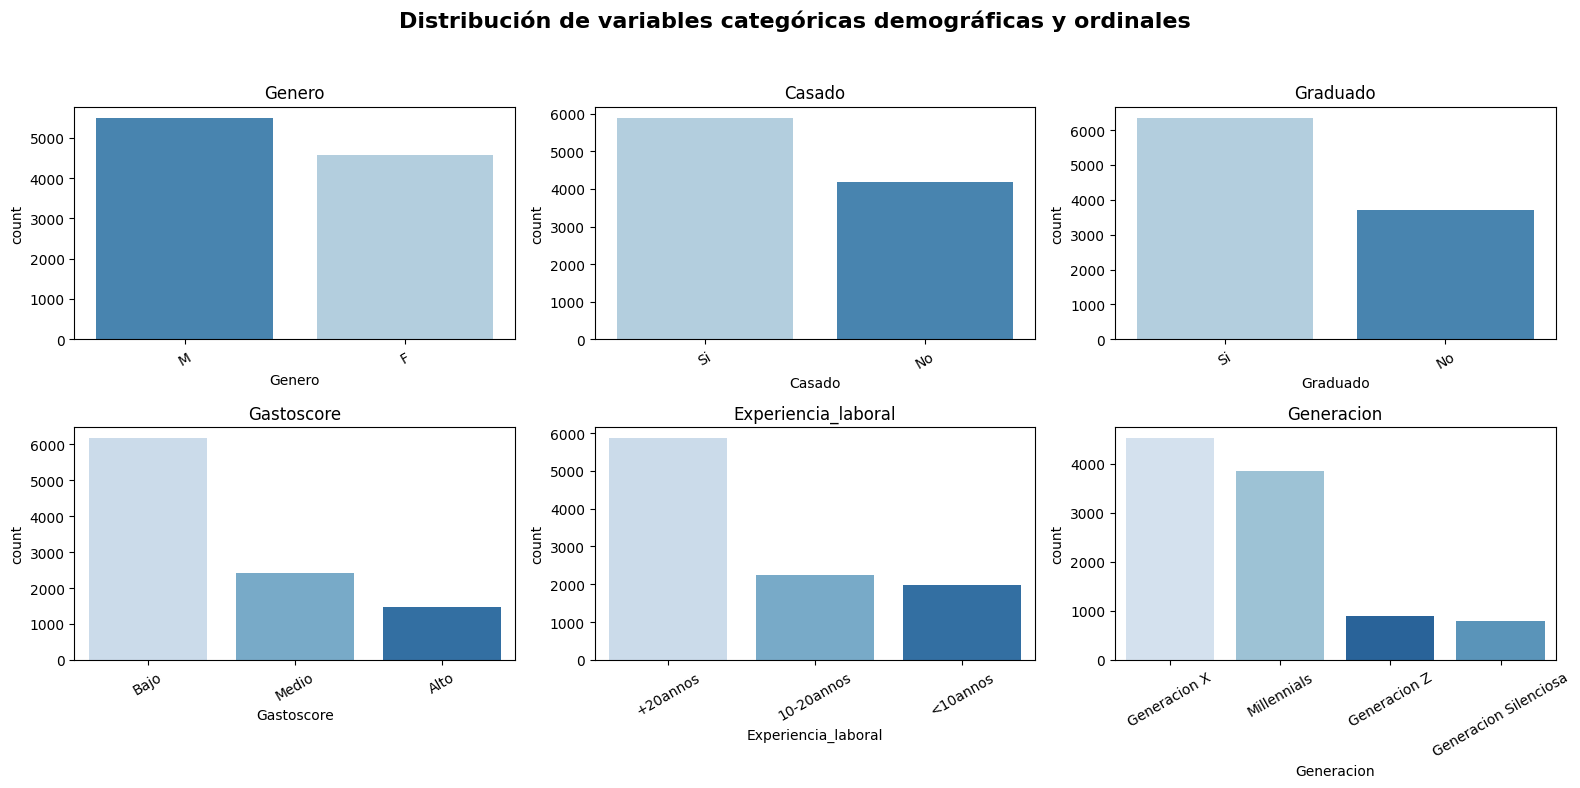

In [34]:
# Distribución de variables categóricas demográficas y ordinales.
categoricas_ordenadas = ['Genero', 'Casado', 'Graduado', 'Gastoscore', 'Experiencia_laboral', 'Generacion']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('Distribución de variables categóricas demográficas y ordinales', fontsize=16, fontweight='bold')
axes = axes.flatten()

for i, col in enumerate(categoricas_ordenadas):
    sns.countplot(data=df, x=col, ax=axes[i],
              order=df[col].value_counts().index,
              hue=df[col], palette='Blues', legend=False)
    axes[i].set_title(f'{col}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### **Comparación de la tasa de abandono por variables categóricas.**
El análisis de la variable cruzado con otras variables permite detectar factores de riesgo asociados a la baja de clientes. Este análisis tiene un gran valor estratégico, ya que si alguno de los segmentos futuros presenta una tasa elevada de abandono, podría considerarse un grupo de alto riesgo. Las visualizaciones permiten entender qué atributos podrían correlacionarse con mayor propensión a abandonar.

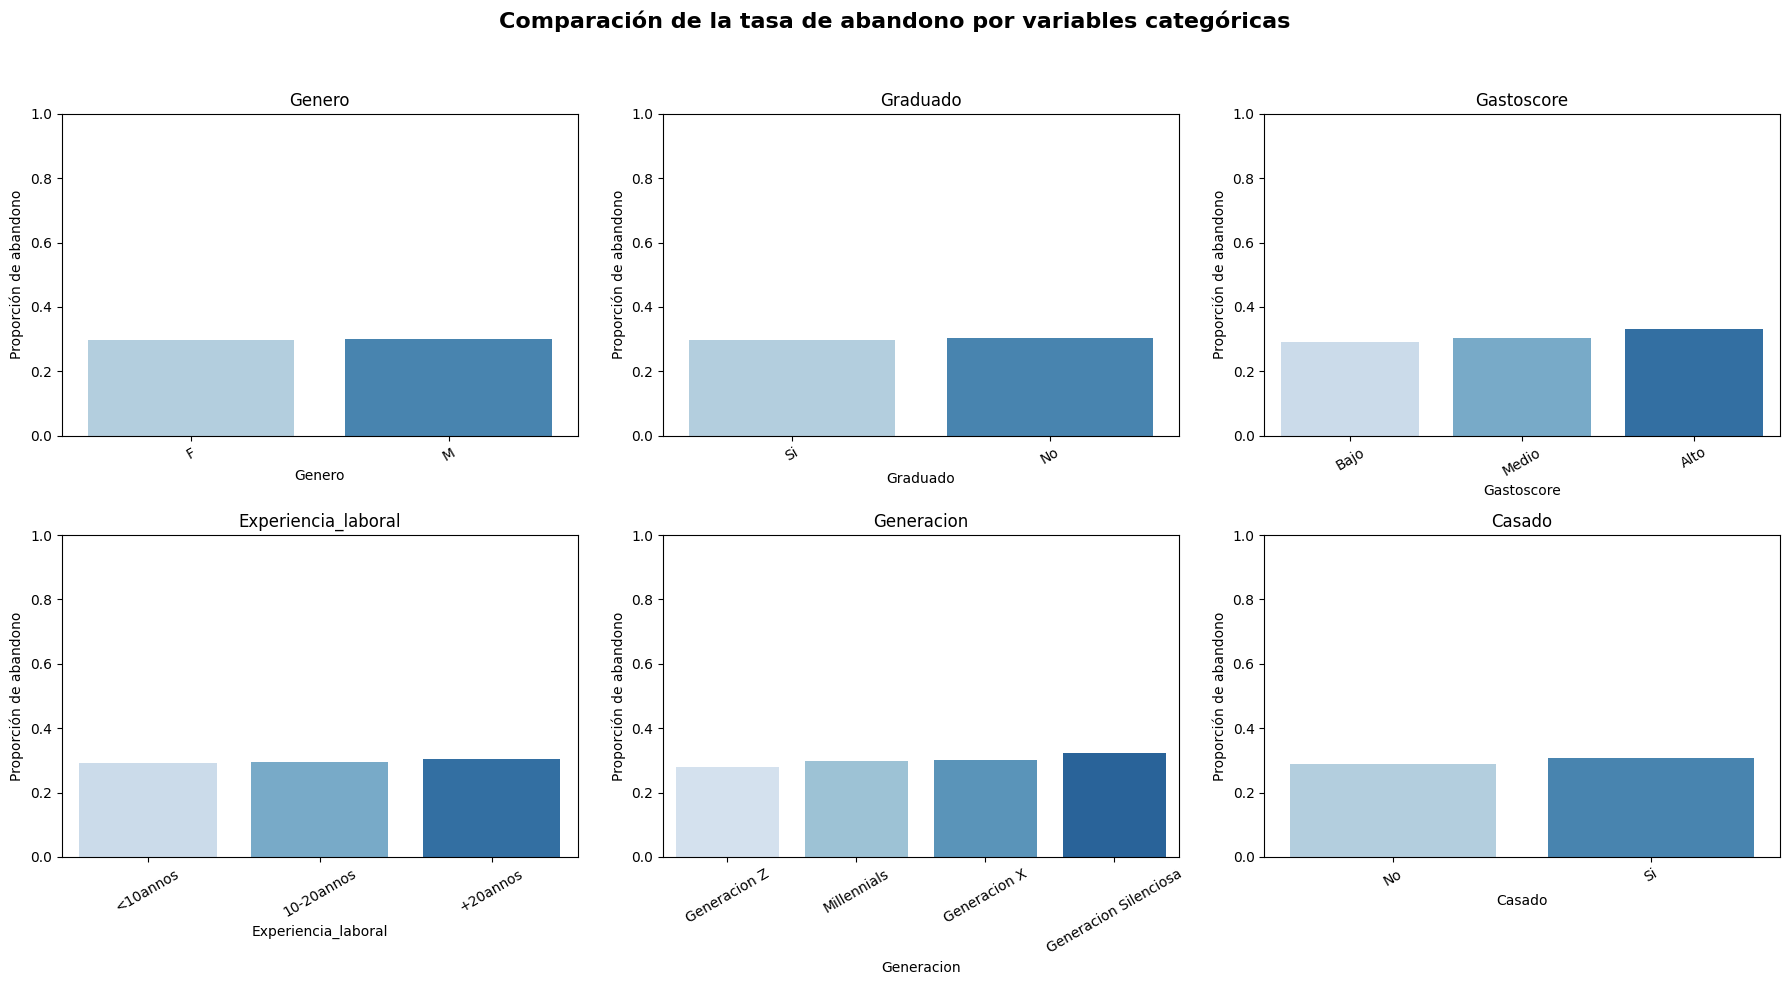

In [35]:
variables_riesgo = ['Genero', 'Graduado', 'Gastoscore', 'Experiencia_laboral', 'Generacion', 'Casado']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparación de la tasa de abandono por variables categóricas', fontsize=16, fontweight='bold')
axes = axes.flatten()

for i, var in enumerate(variables_riesgo):
    abandono_pct = df.groupby(var)['Abandono'].mean().sort_values()
    sns.barplot(x=abandono_pct.index, y=abandono_pct.values, ax=axes[i], hue=abandono_pct.index, palette='Blues', legend=False)
    axes[i].set_title(f'{var}', fontsize=12)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel('Proporción de abandono')
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

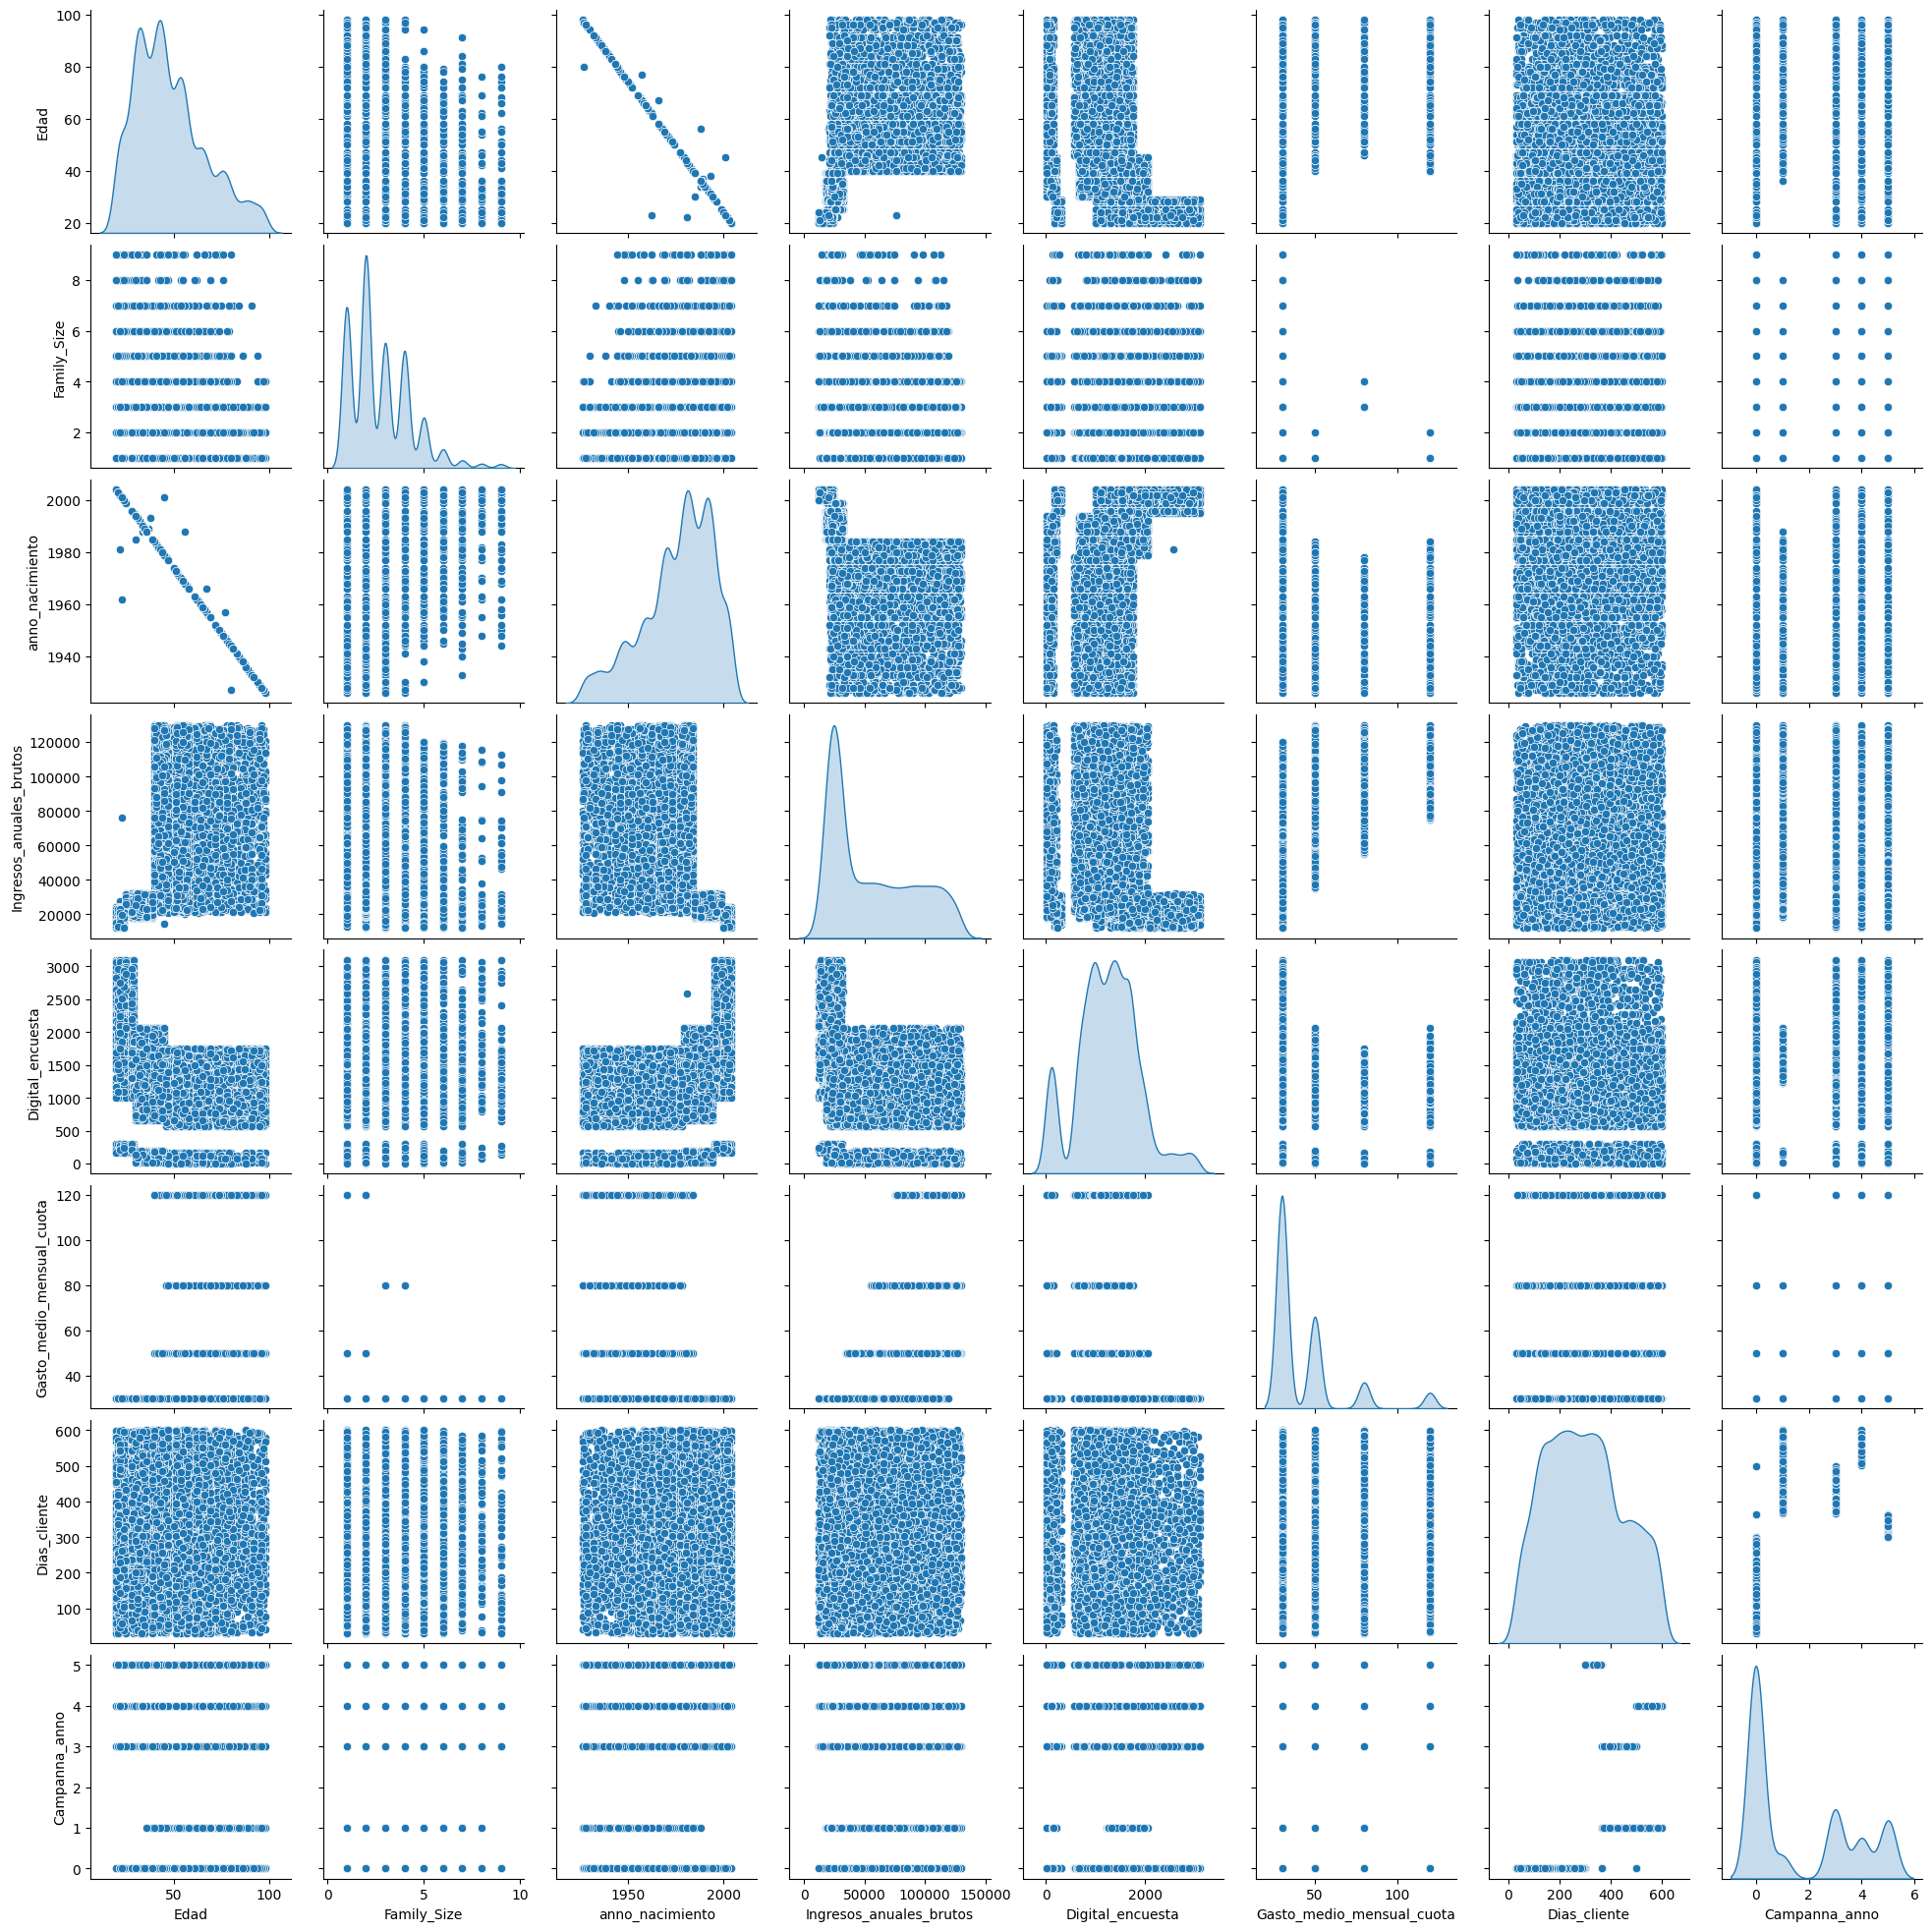

In [36]:
sns.pairplot(df.select_dtypes(include=['number', 'float']), diag_kind="kde")
plt.show()

## **Feature Engineering.**
El preprocesamiento de datos es una etapa fundamental en la construcción de cualquier modelo de predicción. En este notebook, aplicaremos técnicas para t**ransformar y preparar el dataset** antes de su uso en el modelado.

Dado que en el análisis exploratorio del notebook anterior, identificamos la presencia de **variables categóricas, creación de nuevas características y selección de características relevantes para el modelo**.

### **Selección de variables categóricas y continuas.**
Para realizar correctamente un ánalisis de datos debemos de distinguir entre las variables categóricas, variables que representan diferentes categorías o grupos, y continuas, variables que pueden tomar cualquier valor dentro de un rango determinado.

In [249]:
df = df_clean.copy() # Copia para evitar cargar datos nuevamente.

In [250]:
df.nunique()

Genero                          2
Casado                          2
Edad                           69
Graduado                        2
Profesion                       9
Experiencia_laboral             3
Gastoscore                      3
Family_Size                     9
anno_nacimiento                67
Generacion                      4
Ingresos_anuales_brutos      9277
Provincia                      50
Digital_encuesta              176
Gasto_medio_mensual_cuota       4
Abandono                        2
Dias_cliente                  571
Campanna_anno                   5
dtype: int64

In [251]:
v_continuas = []
v_categoricas = []
for i in df.columns:
    if df[i].nunique() > 55 or df[i].dtypes in ['float64', 'int64']:
        v_continuas.append(i)
    else:
        v_categoricas.append(i)

print('Variables continuas: {}'.format(', '.join(v_continuas)))
print('Variables categóricas: {}'.format(', '.join(v_categoricas)))

Variables continuas: Edad, Family_Size, anno_nacimiento, Ingresos_anuales_brutos, Digital_encuesta, Gasto_medio_mensual_cuota, Dias_cliente, Campanna_anno
Variables categóricas: Genero, Casado, Graduado, Profesion, Experiencia_laboral, Gastoscore, Generacion, Provincia, Abandono


#### **Tratamiento de variables categóricas.**
Para preparar adecuadamente las variables categóricas en un modelo de segmentación no supervisado, como el clustering, es necesario seguir un enfoque estructurado que garantice eficiencia y coherencia con los objetivos del análisis.

In [252]:
df[v_categoricas].head(3)

,Genero,Casado,Graduado,Profesion,Experiencia_laboral,Gastoscore,Generacion,Provincia,Abandono
ID,,,,,,,,,
CLI10,F,Si,Si,Ingeniero,+20annos,Bajo,Generacion X,Segovia,True
CLI100,M,Si,Si,Medico,+20annos,Medio,Generacion X,Alicante,True
CLI1000,M,Si,Si,Artista,+20annos,Medio,Generacion X,Toledo,False


In [253]:
df[v_categoricas].nunique()

Genero                  2
Casado                  2
Graduado                2
Profesion               9
Experiencia_laboral     3
Gastoscore              3
Generacion              4
Provincia              50
Abandono                2
dtype: int64

In [254]:
df[v_categoricas].describe()

,Genero,Casado,Graduado,Profesion,Experiencia_laboral,Gastoscore,Generacion,Provincia,Abandono
count,10065,10065,10065,10065,10065,10065,10065,10065,10065
unique,2,2,2,9,3,3,4,50,2
top,M,Si,Si,Artista,+20annos,Bajo,Generacion X,Madrid,False
freq,5492,5890,6347,3169,5857,6166,4520,307,7054


Antes de proceder con la codificación de las variables categóricas, es fundamental realizar una revisión de los valores únicos presentes en cada una de ellas. Este paso nos permite identificar posibles inconsistencias en los datos.

Al analizar los valores únicos, podremos detectar y corregir errores, **agrupar categorías similares** si es necesario y definir la estrategia de codificación más adecuada. Una vez verificada la coherencia de los datos, aplicaremos **OrdinalEncoder**, **One-Hot Encoder** o **LabelEncoder** según corresponda.

In [255]:
print('Valores únicos de las variables categóricas:')
for col in v_categoricas:
    print(f"- {col}: {df[col].unique()}")

Valores únicos de las variables categóricas:
- Genero: ['F' 'M']
- Casado: ['Si' 'No']
- Graduado: ['Si' 'No']
- Profesion: ['Ingeniero' 'Medico' 'Artista' 'Funcionario' 'Otros' 'Ejecutivo'
 'Construccion' 'Negocios/empresa' 'Servicios']
- Experiencia_laboral: ['+20annos' '10-20annos' '<10annos']
- Gastoscore: ['Bajo' 'Medio' 'Alto']
- Generacion: ['Generacion X' 'Millennials' 'Generacion Silenciosa' 'Generacion Z']
- Provincia: ['Segovia' 'Alicante' 'Toledo' 'Leon' 'LLeida' 'Ciudad Real' 'Ávila'
 'Guipúzcoa' 'Vizcaya' 'Orense' 'Castellon' 'Pontevedra' 'Almería'
 'Valladolid' 'Jaen' 'Lugo' 'Santa Cruz de Tenerife' 'Albacete' 'Huelva'
 'Salamanca' 'Ceuta' 'Baleares' 'Gerona' 'Barcelona' 'Sevilla'
 'Guadalajara' 'Soria' 'Caceres' 'Madrid' 'Cordoba' 'Burgos' 'Navarra'
 'Melilla' 'Granada' 'Badajoz' 'Valencia' 'Tarragona' 'La Coruña'
 'Las Palmas' 'Murcia' 'Palencia' 'La Rioja' 'Teruel' 'Zamora' 'Zaragoza'
 'Álava' 'Cuenca' 'Huesca' 'Cadiz' 'Malaga']
- Abandono: [ True False]


##### **Agrupación de valores.**
La **agrupación de variables categóricas** es un paso clave en el **preprocesamiento de datos** para modelos de **clustering** y análisis con **PCA**. Al reducir el número de categorías, simplificamos la estructura de los datos, lo que permite una **mejor representación** en componentes principales y facilita la formación de **grupos más coherentes**. Además, **disminuye el ruido**, **mejora la eficiencia computacional** y permite identificar **patrones más claros** en la **segmentación de clientes**.

Usar agrupaciones intermedias, con un número reducido pero representativo de categorías. Así se mantiene el equilibrio entre simplicidad y riqueza informativa, mejorando la calidad de los clusters sin perder interpretabilidad.

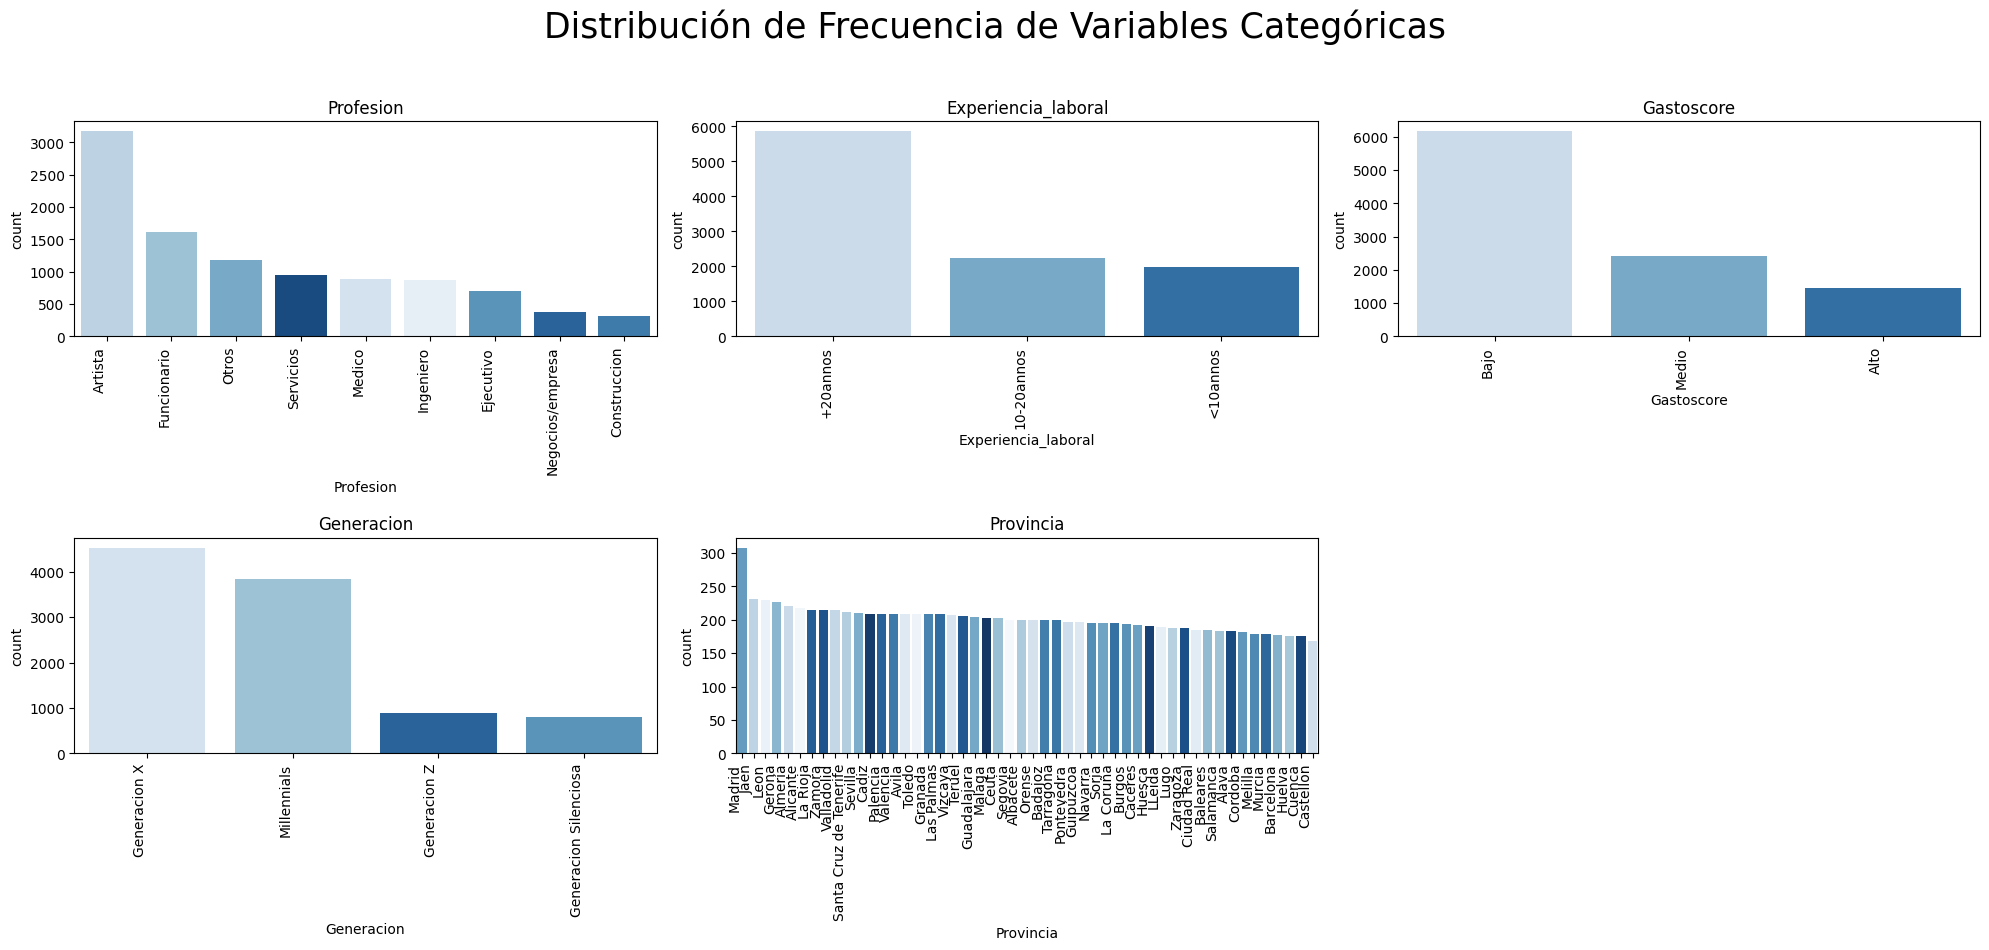

In [256]:
# Tamaño de la figura y la cantidad de filas/columnas.
num_vars = len(v_categoricas)
rows = (num_vars // 3) + (num_vars % 3 > 0)
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(20, rows * 4))  # Ajuste automático.
fig.suptitle("Distribución de Frecuencia de Variables Categóricas", fontsize=25)
axes = axes.flatten()

# Graficación de cada categoría.
for i, col in enumerate([col for col in v_categoricas if df[col].nunique() > 2]):
    sns.countplot(data=df, x=col, ax=axes[i], hue=col, legend=False, order=df[col].value_counts().index, palette="Blues")
    axes[i].set_title(col)
    axes[i].set_xticks(range(len(df[col].value_counts().index)))
    axes[i].set_xticklabels(df[col].value_counts().index, rotation=90, ha="right")

# Ocultar ejes vacíos si hay menos variables que espacios en el grid.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

###### <h5 style="margin: 0; padding: 0;">**Provincias.**</h5>
La variable **`Provincia`** tiene muchas categorías (52 provincias en España), lo que puede generar problemas en el modelo, especialmente si algunas provincias tienen muy pocas observaciones. Agrupar las provincias por **Comunidad Autónoma** es una estrategia útil para simplificar la variable y mejorar el rendimiento del modelo.

In [257]:
# Definir diccionario de clasificación por región geográfica.
region_dict = {
    "Andalucia": ["Almería", "Cadiz", "Cordoba", "Granada", "Huelva", "Jaen", "Malaga", "Sevilla"],
    "Aragon": ["Huesca", "Teruel", "Zaragoza"],
    "Asturias": ["Asturias"],
    "Baleares": ["Baleares"],
    "Canarias": ["Las Palmas", "Santa Cruz de Tenerife"],
    "Cantabria": ["Cantabria"],
    "Castilla y Leon": ["Ávila", "Burgos", "Leon", "Palencia", "Salamanca", "Segovia", "Soria", "Valladolid", "Zamora"],
    "Castilla La Mancha": ["Albacete", "Ciudad Real", "Cuenca", "Guadalajara", "Toledo"],
    "Cataluña": ["Barcelona", "Gerona", "Lerida", "Tarragona", "LLeida"],
    "Extremadura": ["Badajoz", "Caceres"],
    "Galicia": ["Coruña", "Lugo", "Orense", "Pontevedra", "La Coruña"],
    "Madrid": ["Madrid"],
    "Murcia": ["Murcia"],
    "Navarra": ["Navarra"],
    "Pais Vasco": ["Álava", "Guipúzcoa", "Vizcaya"],
    "La Rioja": ["La Rioja"],
    "Valencia": ["Alicante", "Castellon", "Valencia"],
    "Ceuta y Melilla": ["Ceuta", "Melilla"]
}

In [258]:
# Función genérica para clasificar un valor según un diccionario de agrupación.
def clasificar_valor(valor: str, mapping_dict: dict, default=None):
    '''
    Args:
        valor: Valor a clasificar.
        mapping_dict: Diccionario con la estructura {clave_destino: [valores_origen]}.
        default: Valor por defecto si no se encuentra ninguna coincidencia.
    '''
    for categoria, valores in mapping_dict.items():
        if valor in valores:
            return categoria
    return default  # Para manejar valores fuera de lista.

In [259]:
# Aplicar la clasificación.
df["Comunidad_Autonoma"] = df["Provincia"].apply(lambda x: clasificar_valor(x, region_dict))
df[df['Comunidad_Autonoma'].isnull()]['Provincia'].unique() # Verificar si hay provincias no clasificadas.

array([], dtype=object)

In [260]:
df.drop(columns=["Provincia"], inplace=True)

In [261]:
v_categoricas.remove("Provincia")
v_categoricas.append("Comunidad_Autonoma")

Inicialmente, se consideró la agrupación de las provincias por **Comunidades Autónomas**, lo cual ofrecía una representación administrativa y política precisa del territorio. Sin embargo, esta opción genera **17 categorías distintas**, lo que **aumenta la complejidad** del modelo y puede dificultar la interpretación de los resultados en el análisis de componentes principales (PCA) y en el clustering.

Para hacer la segmentación más **eficiente y accionable desde una perspectiva de negocio**, se propone una **agrupación alternativa por zonas geográficas** (Norte, Sur, Centro, Este, Oeste, Islas). Esta simplificación:
- Reduce el número de categorías a **5–7 grupos**, facilitando la codificación y análisis.
- Mejora la **coherencia espacial** en los clusters.
- Permite identificar **patrones regionales amplios** que son más relevantes para estrategias de marketing y retención a gran escala.
- Conserva el contexto geográfico sin perder la capacidad de obtener insights significativos.

In [262]:
# Diccionario para agrupar Comunidades Autónomas en zonas.
zona_dict = {
    "Norte": ["Cantabria", "Pais Vasco", "Navarra", "La Rioja"],
    "Noroeste": ["Galicia", "Asturias", "Castilla y Leon"],
    "Centro": ["Castilla La Mancha", "Madrid", "Extremadura"],
    "Noreste": ["Cataluña", "Aragon", "Baleares"],
    "Levante": ["Valencia", "Murcia"],
    "Sur": ["Andalucia"],
    "Periferia": ["Canarias", "Ceuta y Melilla"],
}

df["Zona"] = df["Comunidad_Autonoma"].apply(lambda x: clasificar_valor(x, zona_dict))
df[df['Zona'].isnull()]['Comunidad_Autonoma'].unique() # Valores no clasificados.

array([], dtype=object)

In [263]:
df.drop(columns=["Comunidad_Autonoma"], inplace=True)
v_categoricas.remove("Comunidad_Autonoma")
v_categoricas.append("Zona")

###### <h5 style="margin: 0; padding: 0;">**Profesión.**</h5>
Para facilitar el análisis y mejorar la calidad del modelo de segmentación, se ha decidido **agrupar la variable `Profesión` en sectores laborales generales**. Esta agrupación permite reducir la complejidad del conjunto de datos y aportar contexto sobre el perfil profesional del cliente, sin duplicar información ya incluida en otras variables como ingresos o gasto mensual.

El enfoque no busca reflejar el nivel económico —ya cubierto por variables específicas—, sino ofrecer una **visión más cualitativa del entorno laboral y el estilo de vida**, lo cual puede influir en las preferencias, hábitos de consumo y respuesta a estrategias de retención.

In [264]:
df['Profesion'].value_counts()

Profesion
Artista             3169
Funcionario         1610
Otros               1180
Servicios            947
Medico               894
Ingeniero            866
Ejecutivo            708
Negocios/empresa     378
Construccion         313
Name: count, dtype: int64

**Justificación: Agrupaciones de Profesión.**
1. **Empresarial:** Ejecutivo, Negocios/empresa. *Por qué:* Ambos perfiles implican funciones de liderazgo, gestión de recursos y toma de decisiones. Aunque pueden diferir en nivel económico, comparten una lógica de trabajo orientada a la estrategia, el rendimiento y la dirección.

2. **Servicios:** Servicios, Artista *Por qué:* Suelen estar asociados a entornos laborales más flexibles, informales o autónomos, lo cual puede influir en el tipo de productos y comunicación que prefieren.

3. **Profesiones técnicas y especializadas:** Ingeniero, Médico. *Por qué:* Son profesiones con alto grado de especialización técnica y formación académica. Representan perfiles estables, con pensamiento analítico y posiblemente mayor apertura a soluciones tecnológicas.

4. **Administración pública:** Funcionario. *Por qué:* Se trata de un perfil específico, con estabilidad laboral, estructura jerárquica y posiblemente menor variabilidad en ingresos o consumo. Su comportamiento puede diferir de los perfiles del sector privado.

5. **Trabajo manual:** Construcción. *Por qué:* Empleo físico, operativo, a menudo ligado a contratos temporales o por proyecto. Este grupo puede tener un patrón de consumo diferente y prioridades más prácticas.

6. **Otros:** Otros. *Por qué:* Categoría residual para profesiones no clasificables o con poca frecuencia.

In [265]:
# Diccionario para agrupar profesiones.
profesion_dict = {
    "Empresarial": ["Ejecutivo", "Negocios/empresa"],
    "Técnico": ["Medico", "Ingeniero"],
    "Servicios": ["Servicios", "Artista"],
    "Funcionario": ["Funcionario"],
    "Construcción": ["Construccion"],
    "Otros": ["Otros"],
}
df["Profesion"] = df["Profesion"].apply(lambda x: clasificar_valor(x, profesion_dict))
df['Profesion'].isnull().sum() # Verificar si hay valores nulos después de la clasificación.

np.int64(0)

##### **Codificación para el modelo.**
Una vez agrupadas, las variables categóricas se deben **convertir en variables numéricas** para poder ser procesadas por algoritmos como PCA o K-Means, que no aceptan texto como entrada.

- Para variables **sin un orden lógico**, se aplica **One-Hot Encoding**, que genera una columna por categoría sin asignar jerarquías artificiales.
- Para variables **con un orden natural**, se utiliza **Ordinal Encoding**, respetando la secuencia implícita entre los niveles.

> En cambio, **no se utiliza LabelEncoder** en este tipo de codificación, ya que asigna valores numéricos enteros a cada categoría sin considerar su significado. Esto **puede introducir un orden ficticio entre clases que no lo tienen**, y afectar negativamente algoritmos basados en distancia como PCA o K-Means, que interpretan esos números como relaciones reales. Por ejemplo, que una categoría tenga valor 2 y otra 0 no significa que estén más alejadas en comportamiento. **Solo se utilizaria en variables binarias.**

Este tratamiento permite representar correctamente la información sin introducir sesgos ni relaciones ficticias, y garantiza que cada variable aporte valor real al modelo de segmentación.

In [266]:
print('Valores únicos de las variables categóricas:')
for col in v_categoricas:
    print(f"- {col}: {df[col].unique()}")

Valores únicos de las variables categóricas:
- Genero: ['F' 'M']
- Casado: ['Si' 'No']
- Graduado: ['Si' 'No']
- Profesion: ['Técnico' 'Servicios' 'Funcionario' 'Otros' 'Empresarial' 'Construcción']
- Experiencia_laboral: ['+20annos' '10-20annos' '<10annos']
- Gastoscore: ['Bajo' 'Medio' 'Alto']
- Generacion: ['Generacion X' 'Millennials' 'Generacion Silenciosa' 'Generacion Z']
- Abandono: [ True False]
- Zona: ['Noroeste' 'Levante' 'Centro' 'Noreste' 'Norte' 'Sur' 'Periferia']


###### <h5 style="margin: 0; padding: 0;">**Label Encoding.**</h5>
Como parte del preprocesamiento de datos, se han identificado **variables categóricas binarias que no presentan un orden jerárquico** entre sus categorías. Para estas variables, se ha utilizado **Label Encoding**, ya que al tener únicamente dos clases, la codificación numérica no introduce sesgos ni relaciones ficticias en el modelo.

Este tipo de codificación es eficiente y adecuada en estos casos, ya que transforma las categorías a valores numéricos (por ejemplo, 0 y 1) sin afectar la estructura de los datos ni la calidad del análisis posterior.

In [267]:
# Label Encoding: Variables binarias sin orden.
label_vars = [col for col in v_categoricas if df[col].nunique() == 2]
label_vars

['Genero', 'Casado', 'Graduado', 'Abandono']

In [268]:
for col in label_vars:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

###### <h5 style="margin: 0; padding: 0;">**Ordinal Encoding.**</h5>
En el preprocesamiento de datos, se identificaron variables categóricas que presentan un **orden lógico y jerárquico** entre sus categorías. Para estas variables se aplicó **Ordinal Encoding**, ya que este método permite mantener la **secuencia natural** sin convertirlas en múltiples columnas, a diferencia de One-Hot Encoding. El uso de codificación ordinal es especialmente adecuado en este caso porque:
- Preserva el orden implícito en las categorías.
- Permite que el modelo interprete la progresión entre niveles.
- Es compatible con técnicas como PCA y K-Means, al producir una única columna numérica por variable.

Las variables tratadas con codificación ordinal fueron:
1. **`Gasto Score`**: `'Bajo' < 'Medio' < 'Alto'`. Representa el **nivel de gasto del cliente**, de menor a mayor.
2. **`Experiencia Laboral`**: `'<10 años' < '10-20 años' < '+20 años'`. Estas categorías tienen un orden temporal y lógico claro: Esto refleja **progresión en experiencia profesional**.
3. **`Generación`**: `'Generación Silenciosa' < 'Generación X' < 'Millennials' < 'Generación Z'`
Se ha tratado como ordinal ya que representa una **evolución cronológica entre grupos etarios**. Esta variable es relevante para el análisis, ya que las **generaciones difieren en nivel de digitalización, hábitos de consumo y relación con los servicios**, aportando contexto útil a la segmentación.

In [269]:
# Ordinal Encoding: Variables categóricas con orden.
ordinal_map = {
    'Experiencia_laboral': ['<10annos', '10-20annos', '+20annos'],
    'Gastoscore': ['Bajo', 'Medio', 'Alto'],
    'Generacion': ['Generacion Silenciosa', 'Generacion X', 'Millennials', 'Generacion Z'],
}
ordinal_vars = [col for col in v_categoricas if col in ordinal_map]
ordinal_vars

['Experiencia_laboral', 'Gastoscore', 'Generacion']

In [270]:
for col in ordinal_vars:
    encoder = OrdinalEncoder(categories=[ordinal_map[col]])
    df[col] = encoder.fit_transform(df[[col]])

###### <h5 style="margin: 0; padding: 0;">**One-Hot Encoding.**</h5>
Algunas variables categóricas en el conjunto de datos **no presentan un orden lógico o jerárquico entre sus categorías**, por lo tanto, no pueden ser representadas de forma ordinal. Para estas variables, se ha utilizado **One-Hot Encoding**, una técnica que transforma cada categoría en una nueva columna binaria (0 o 1), evitando la introducción de relaciones numéricas artificiales entre clases.
Este método es especialmente adecuado cuando:
- Las categorías son **nominales** (sin orden),
- Es necesario mantener la **independencia entre clases**,
- Se trabaja con modelos basados en **distancia**, como PCA y K-Means, donde una codificación incorrecta puede distorsionar los resultados.

In [271]:
onehot_vars = [col for col in v_categoricas if col not in ordinal_map and df[col].nunique() > 2]
cols_antes = df.shape[1] # Guardar cantidad de columnas antes.

# One-Hot Encoding: Variables categóricas sin orden.
df = pd.get_dummies(df, columns=onehot_vars, drop_first=False)
df[df.columns.difference(onehot_vars)] = df[df.columns.difference(onehot_vars)].astype(int)

cols_despues = df.shape[1] # Guardar cantidad de columnas después.

print(f"Se aplicó One-Hot Encoding a las variables: {onehot_vars}")
print(f"Se crearon {cols_despues - cols_antes} columnas nuevas.")

Se aplicó One-Hot Encoding a las variables: ['Profesion', 'Zona']
Se crearon 11 columnas nuevas.


In [272]:
df.head(10)

,Genero,Casado,Edad,Graduado,Experiencia_laboral,Gastoscore,Family_Size,anno_nacimiento,Generacion,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Campanna_anno,Profesion_Construcción,Profesion_Empresarial,Profesion_Funcionario,Profesion_Otros,Profesion_Servicios,Profesion_Técnico,Zona_Centro,Zona_Levante,Zona_Noreste,Zona_Noroeste,Zona_Norte,Zona_Periferia,Zona_Sur
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CLI10,0,1,67,1,2,0,3,1957,1,93442,1385,80,1,195,0,0,0,0,0,0,1,0,0,0,1,0,0,0
CLI100,1,1,64,1,2,1,2,1960,1,99774,1052,50,1,360,5,0,0,0,0,0,1,0,1,0,0,0,0,0
CLI1000,1,1,65,1,2,1,3,1959,1,36756,1717,30,0,407,3,0,0,0,0,1,0,1,0,0,0,0,0,0
CLI10000,1,0,33,0,1,0,4,1991,2,24616,1606,30,0,544,4,0,0,1,0,0,0,0,0,0,1,0,0,0
CLI10001,1,1,52,0,2,1,2,1972,1,29834,1346,30,1,170,0,0,0,0,1,0,0,0,0,1,0,0,0,0
CLI10002,1,1,76,0,2,0,1,1948,1,88523,158,120,0,358,5,0,0,0,0,1,0,1,0,0,0,0,0,0
CLI10003,1,1,45,1,2,0,5,1979,1,112808,939,30,0,442,3,0,0,0,1,0,0,0,0,0,1,0,0,0
CLI10004,1,1,36,0,1,0,6,1988,2,18885,824,30,0,124,0,0,1,0,0,0,0,0,0,0,0,1,0,0
CLI10005,1,0,30,1,0,0,5,1994,2,21358,1675,30,0,70,0,0,0,1,0,0,0,0,0,0,0,1,0,0


#### **Tratamiento de variables continuas.**
El preprocesamiento de variables continuas es una etapa clave para mejorar la calidad del modelo y garantizar que las características numéricas aporten información relevante. En este apartado, hemos abordado distintas técnicas para optimizar estas variables y reducir posibles sesgos en el análisis.

In [273]:
df[v_continuas].head(3)

,Edad,Family_Size,anno_nacimiento,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Dias_cliente,Campanna_anno
ID,,,,,,,,
CLI10,67,3,1957,93442,1385,80,195,0
CLI100,64,2,1960,99774,1052,50,360,5
CLI1000,65,3,1959,36756,1717,30,407,3


In [274]:
df[v_continuas].describe()

,Edad,Family_Size,anno_nacimiento,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Dias_cliente,Campanna_anno
count,10065.000000,10065.000000,10065.000000,10065.000000,10065.000000,10065.000000,10065.000000,10065.000000
mean,48.042822,2.736612,1975.955390,55447.100845,1244.819076,43.100845,297.589468,1.688525
std,18.350550,1.541773,18.351071,34687.339858,621.543339,22.045900,148.700598,1.985653
min,20.000000,1.000000,1926.000000,12003.000000,7.000000,30.000000,30.000000,0.000000
25%,34.000000,2.000000,1966.000000,25091.000000,857.000000,30.000000,178.000000,0.000000
50%,45.000000,2.000000,1979.000000,43209.000000,1261.000000,30.000000,288.000000,0.000000
75%,58.000000,4.000000,1990.000000,85118.000000,1652.000000,50.000000,400.000000,3.000000
max,98.000000,9.000000,2004.000000,129963.000000,3099.000000,120.000000,600.000000,5.000000


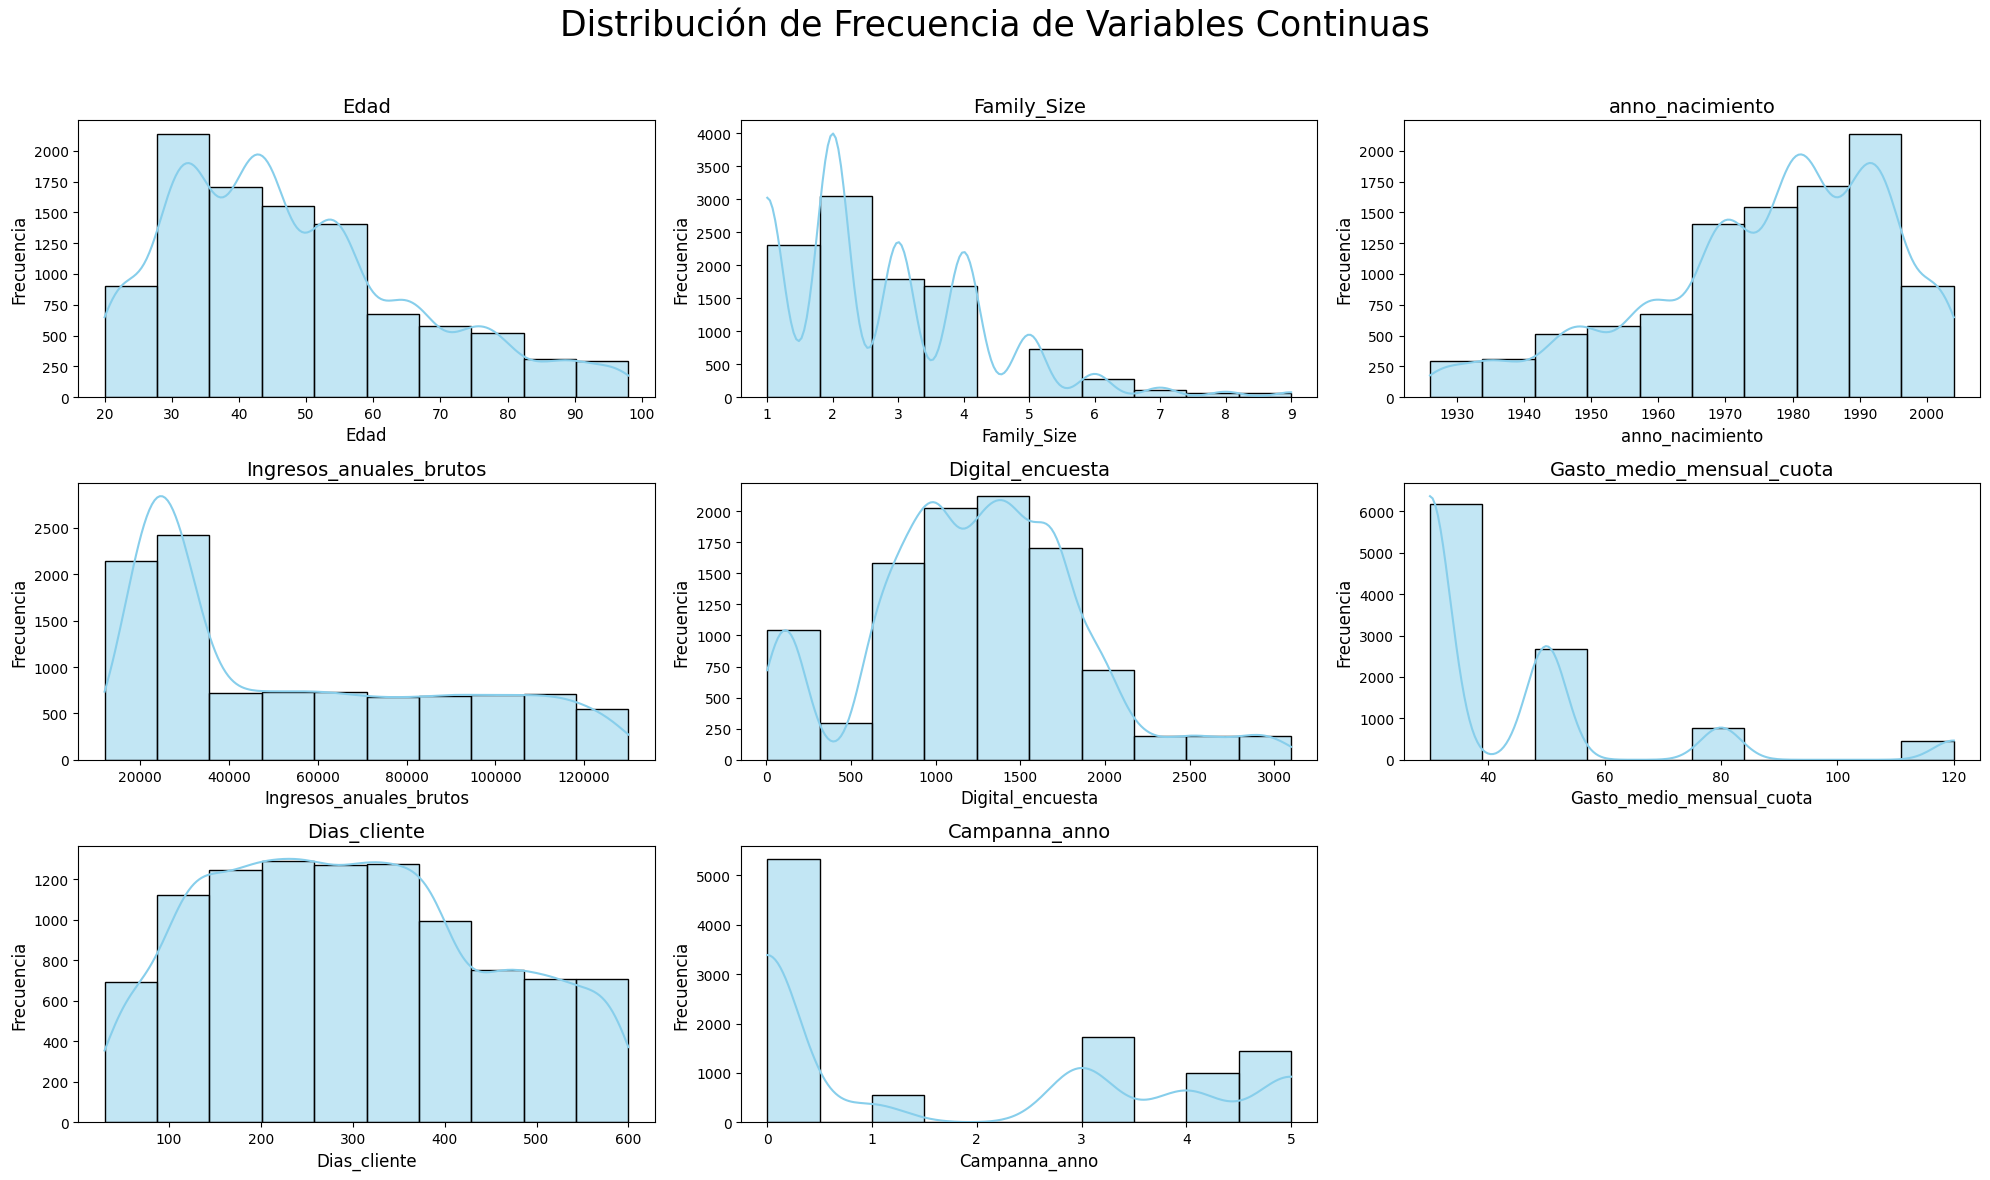

In [275]:
# Tamaño de la figura y la cantidad de filas/columnas.
num_vars = len(v_continuas)
rows = (num_vars // 3) + (num_vars % 3 > 0)
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(20, rows * 4))  # Ajuste automático.
fig.suptitle("Distribución de Frecuencia de Variables Continuas", fontsize=25)
axes = axes.flatten()

# Graficación de cada categoría.
for i, col in enumerate(v_continuas):
    sns.histplot(data=df, x=col, ax=axes[i], kde=True, bins=10, color="skyblue")
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("Frecuencia", fontsize=12)

# Ocultar ejes vacíos si hay menos variables que espacios en el grid.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Durante el análisis de las variables numéricas del dataset, se identificaron algunas columnas con baja cardinalidad y comportamiento discreto, lo cual llevó a cuestionar si debían tratarse como variables continuas, ordinales o categóricas. Las variables analizadas fueron:
- **`Family Size`:** Aunque representa una magnitud numérica (número de miembros), su rango es limitado y discreto. Tiene **orden implícito**, pero no se identificó un beneficio claro de transformarla para el modelo actual. **Se mantiene como valor numérico** sin codificación adicional.
- **`Gasto Medio Mensual Cuota`:** Variable numérica con solo cuatro valores únicos, correspondiente a tramos de gasto mensual. Aunque podría tratarse como ordinal, no se observaron efectos negativos al mantenerla en formato entero. **Se conserva sin transformación, dado que no distorsiona las métricas de distancia.**
- **`Campaña Año`:** Representa tipos de campañas anuales con valores que no siguen una escala continua ni un orden claro. Aplicar una codificación ordinal introduciría relaciones artificiales entre categorías. Se aplica **One-Hot Encoding** para evitar imponer jerarquías inexistentes entre tipos de campaña y preservar su carácter nominal.

In [276]:
df['Campanna_anno'].value_counts()

Campanna_anno
0    5329
3    1729
5    1451
4     999
1     557
Name: count, dtype: int64

In [277]:
onehot_var = 'Campanna_anno'
valores_originales = sorted(df[onehot_var].dropna().unique())
cols_antes = df.shape[1]

df = pd.get_dummies(df, columns=[onehot_var], prefix='Campaña_', drop_first=False)
cols_nuevas = [col for col in df.columns if col.startswith('Campaña_')]
df[cols_nuevas] = df[cols_nuevas].astype(int)

cols_despues = df.shape[1]
nuevas_cols = cols_despues - cols_antes

print(f"One-Hot Encoding aplicado a '{onehot_var}' con valores: {valores_originales}")
print(f"Se crearon {nuevas_cols} columnas nuevas.")

One-Hot Encoding aplicado a 'Campanna_anno' con valores: [np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5)]
Se crearon 4 columnas nuevas.


In [278]:
df.head()

,Genero,Casado,Edad,Graduado,Experiencia_laboral,Gastoscore,Family_Size,anno_nacimiento,Generacion,Ingresos_anuales_brutos,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Profesion_Construcción,Profesion_Empresarial,Profesion_Funcionario,Profesion_Otros,Profesion_Servicios,Profesion_Técnico,Zona_Centro,Zona_Levante,Zona_Noreste,Zona_Noroeste,Zona_Norte,Zona_Periferia,Zona_Sur,Campaña__0,Campaña__1,Campaña__3,Campaña__4,Campaña__5
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CLI10,0,1,67,1,2,0,3,1957,1,93442,1385,80,1,195,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
CLI100,1,1,64,1,2,1,2,1960,1,99774,1052,50,1,360,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
CLI1000,1,1,65,1,2,1,3,1959,1,36756,1717,30,0,407,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
CLI10000,1,0,33,0,1,0,4,1991,2,24616,1606,30,0,544,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
CLI10001,1,1,52,0,2,1,2,1972,1,29834,1346,30,1,170,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


## **Exportación del Dataset Final.**
Una vez finalizado el proceso de limpieza y codificación, exportamos el dataset transformado para su uso directo en la siguiente etapa del proyecto (reducción de dimensionalidad y modelado de clustering).

In [279]:
df.to_csv('../data/processed/IA_Client_Segment_sample_v1.csv', index=True)